### **Zadanie 1 úloha 2**

__Lukáš Bugaj__


__Adrián Maslák__

50/50

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import iqr
from scipy import stats

### Import datasetov

In [27]:
observation_df = pd.read_csv("./069/observation.csv", sep='\t')
station_df = pd.read_csv("./069/station.csv")
patient_df = pd.read_csv("./069/patient.csv",sep = '\t', engine = "python") #toto tu musi byt koli chybnemu datasetu

In [28]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

# A-2b: Identifikácia problémov v dátach
def identify_data_issues(df, dataset_name):
    print(f"\n### Analýza problémov v datasete: {dataset_name} ###")

    # 1. Chýbajúce hodnoty
    missing_values = df.isnull().sum()
    print("\nChýbajúce hodnoty:")
    print(missing_values[missing_values > 0])

    # 2. Duplicitné záznamy
    duplicates = df.duplicated().sum()
    print(f"\nPočet duplicitných záznamov: {duplicates}")
    if duplicates > 0:
        print("Príklady duplicitných záznamov:")
        print(df[df.duplicated()].head())

    # 3. Nejednotné formáty (napr. dátumy)
    if 'revision' in df.columns:
        df['revision'] = df['revision'].apply(parse_date)
        inconsistent_dates = df['revision'].isnull().sum()
        print(f"\nPočet neplatných dátumov v stĺpci 'revision': {inconsistent_dates}")

    # 4. Nevhodná štruktúra (napr. súradnice ako reťazce v patient_df)
    if 'current_location' in df.columns:
        invalid_coords = df['current_location'].str.contains(r'[^\d\.\-\(\), ]', na=True).sum()
        print(f"\nPočet neplatných formátov súradníc: {invalid_coords}")

    # 5. Potenciálne vychýlené hodnoty (súradnice mimo rozsah)
    if 'latitude' in df.columns and 'longitude' in df.columns:
        invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)]['latitude'].count()
        invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)]['longitude'].count()
        print(f"\nNeplatné zemepisné šírky: {invalid_lat}")
        print(f"Neplatné zemepisné dĺžky: {invalid_lon}")
# Spustenie analýzy
print("=== Analýza datasetov ===")
identify_data_issues(station_df, "station.csv")
identify_data_issues(patient_df, "patient.csv")
identify_data_issues(observation_df, "observation.csv")

=== Analýza datasetov ===

### Analýza problémov v datasete: station.csv ###

Chýbajúce hodnoty:
longitude\trevision\tlocation\tstation\tcode\tlatitude    625
dtype: int64

Počet duplicitných záznamov: 644
Príklady duplicitných záznamov:
                                                   longitude\trevision\tlocation\tstation\tcode\tlatitude
120.56528\t24 Jul 2023\tAsia/Manila\tPilar\tPH\...                                                NaN    
73.97117\t2023/11/17\tAsia/Karachi\tNaushahra V...                                                NaN    
59.4839\t2022/11/13\tAsia/Yekaterinburg\tKachka...                                                NaN    
-120.43572\t2017/12/19\tAmerica/Los_Angeles\tSa...                                                NaN    
111.73861\t2016/02/24\tAsia/Shanghai\tChangzhi\...                                                NaN    

### Analýza problémov v datasete: patient.csv ###

Chýbajúce hodnoty:
address              310
job                 1445
resid

✅ Nájdené stĺpce v observation_df: ['SpO₂', 'HR', 'BP', 'Skin Temperature']


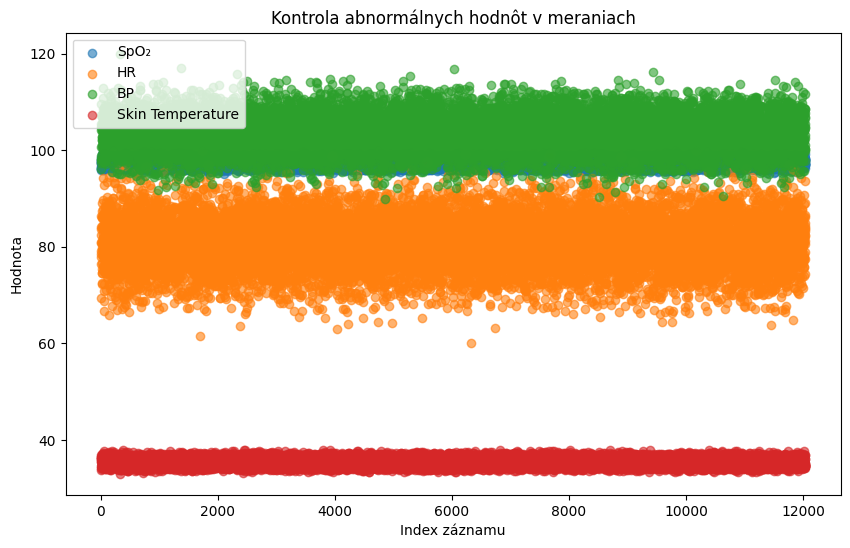

In [25]:
import matplotlib.pyplot as plt
import numpy as np


expected_cols = ['SpO₂', 'HR', 'BP', 'Skin Temperature']
existing_cols = [c for c in expected_cols if c in observation_df.columns]

print("✅ Nájdené stĺpce v observation_df:", existing_cols)

fig, ax = plt.subplots(figsize=(10, 6))

for col in existing_cols:
    y = observation_df[col]
    x = np.arange(len(y))
    ax.scatter(x, y, label=col, alpha=0.6)

if existing_cols:
   ax.legend()
else:
   print("⚠️ Žiadny z očakávaných stĺpcov sa nenašiel v observation_df.")

ax.set_title("Kontrola abnormálnych hodnôt v meraniach")
ax.set_xlabel("Index záznamu")
ax.set_ylabel("Hodnota")
plt.show()



In [26]:
df = observation_df
column = 'HR'
print(f"\n### Detekcia a spracovanie vychýlených hodnôt v stĺpci {column} ###")

    # Technika 1: IQR (odstránenie vychýlených hodnôt)
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
print(f"IQR - Počet vychýlených hodnôt: {len(outliers_iqr)}")
df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Technika 2: Z-skóre (nahradenie hraničnými hodnotami 5% a 95%)
z_scores = np.abs(stats.zscore(df[column].dropna()))
threshold = 3
outliers_z = df[z_scores > threshold][column]
print(f"Z-skóre - Počet vychýlených hodnôt: {len(outliers_z)}")
lower_percentile = df[column].quantile(0.05)
upper_percentile = df[column].quantile(0.95)
df_replaced = df.copy()
df_replaced.loc[z_scores > threshold, column] = df_replaced[column].clip(lower=lower_percentile, upper=upper_percentile)



### Detekcia a spracovanie vychýlených hodnôt v stĺpci HR ###
IQR - Počet vychýlených hodnôt: 80
Z-skóre - Počet vychýlených hodnôt: 29
